### **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime
from typing import List

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTENC, RandomOverSampler

import lightgbm as lgb
from lightgbm import LGBMClassifier

### **Settings**

In [ ]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### **Load Dataset**

In [3]:
train_path = r'D:\Project\Python\Portfolio\Big Data\[Bottleneck] CLS - Spring Leaf Markeing Response\data\train.csv'

df = pd.read_csv(train_path)
df.head()

C:\Users\msi.pc\AppData\Local\Temp\ipykernel_10532\2736376315.py:3: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_path)


,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,...,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,False,False,False,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,6546,6546,6125,76,1,1,9996,111,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,997,999999997,999999997,999999997,999999997,1,997,9996,113,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,BRANCH,1


In [4]:
print(f'Dataset shape: {df.shape}')

Dataset shape: (145231, 1934)


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float64(477), int64(1406), object(51)
memory usage: 2.3 GB


In [6]:
def is_convertable(col: pd.Series) -> bool:
  if col.dtype == np.int64 and\
      col.max() <= np.iinfo(np.int32).max and\
      col.min() >= np.iinfo(np.int32).min: return True
  
  if col.dtype == np.float64 and\
      col.max() <= np.finfo(np.float32).max and\
      col.min() >= np.finfo(np.float32).min: return True
  
  if np.isnan(col.max()): return True
      
  return False

def save_memory(df_origin: pd.DataFrame) -> pd.DataFrame:
  int_cols = df_origin.select_dtypes(np.int64).columns
  float_cols = df_origin.select_dtypes(np.float64).columns
  
  int_cols = [col for col in int_cols if is_convertable(df_origin[col])]
  float_cols = [col for col in float_cols if is_convertable(df_origin[col])]
  
  int_cols = {col: 'int32' for col in int_cols}
  float_cols = {col: 'float32' for col in float_cols}

  df_origin = df_origin.astype(int_cols)
  df_origin = df_origin.astype(float_cols)
  
  return df_origin
  
df = save_memory(df)

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float32(477), int32(1406), object(51)
memory usage: 1.3 GB


### **EDA**

##### **A. Target value**

Ratio of target (1 and 0): 3.300210227104492


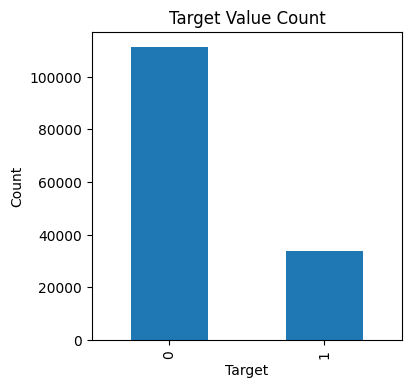

In [8]:
target_dist = df['target'].value_counts().sort_values(ascending=False)
target_dist.plot(kind='bar',
                 figsize=(4, 4),
                 title='Target Value Count',
                 xlabel='Target',
                 ylabel='Count')

mayor_minor_ratio = target_dist[0] / target_dist[1]
print(f'Ratio of target (1 and 0): {mayor_minor_ratio}')

##### **B. Missing value - column**

<Axes: title={'center': 'Top 50 of % of Missing Value vs Feature'}, xlabel='Feature', ylabel='% of Missing Value'>

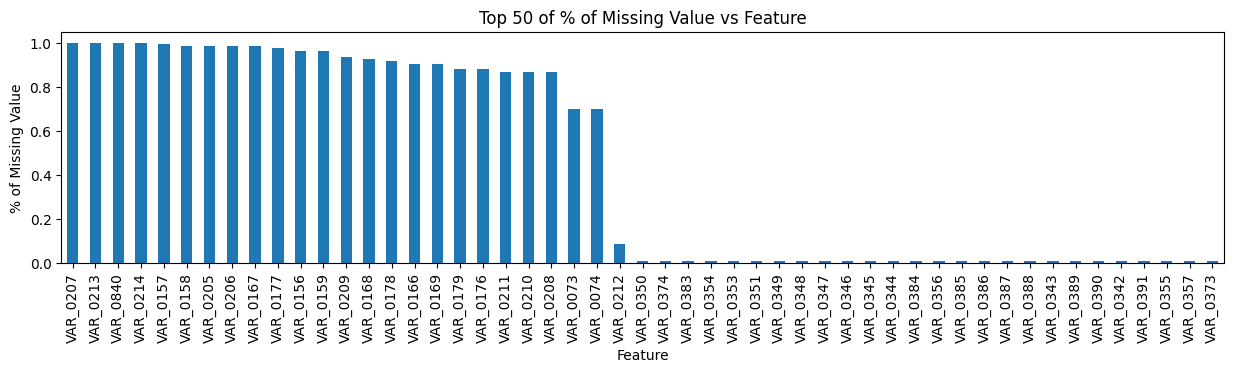

In [9]:
df_cols_null = df.isna().mean().sort_values(ascending=False).drop('target')

df_cols_null[:51].plot(kind='bar',
                       figsize=(15, 3),
                       title=r'Top 50 of % of Missing Value vs Feature',
                       xlabel='Feature',
                       ylabel=r'% of Missing Value')

In [10]:
df_cols_null_70p = df_cols_null[df_cols_null > 0.69]
df_cols_null_70p = df_cols_null_70p.index.to_list()

print(f'Numbers of feature(s): {len(df_cols_null_70p)}\nFeatures: {df_cols_null_70p}')

Numbers of feature(s): 24
Features: ['VAR_0207', 'VAR_0213', 'VAR_0840', 'VAR_0214', 'VAR_0157', 'VAR_0158', 'VAR_0205', 'VAR_0206', 'VAR_0167', 'VAR_0177', 'VAR_0156', 'VAR_0159', 'VAR_0209', 'VAR_0168', 'VAR_0178', 'VAR_0166', 'VAR_0169', 'VAR_0179', 'VAR_0176', 'VAR_0211', 'VAR_0210', 'VAR_0208', 'VAR_0073', 'VAR_0074']


##### **C. Single unique value feature**

In [11]:
df_num_cols = df.select_dtypes(exclude='object').columns
df_cat_cols = df.select_dtypes('object').columns

print(f'Numbers of numerical feature(s): {len(df_num_cols)}')
print(f'Numbers of categorical feature(s): {len(df_cat_cols)}')

Numbers of numerical feature(s): 1883
Numbers of categorical feature(s): 51


<Axes: title={'center': 'Bottom 50 of Numbers of Unique Value(s) vs Feature'}, xlabel='Feature', ylabel='Numbers of Unique Value(s)'>

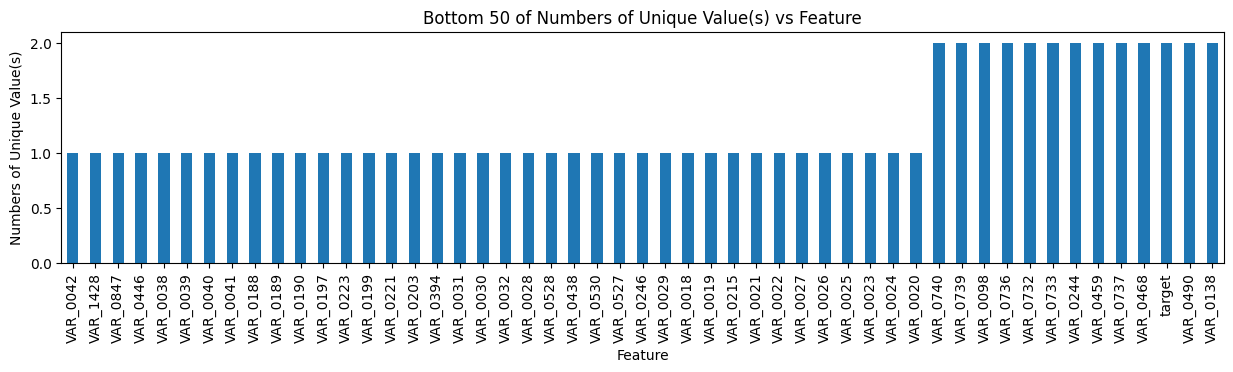

In [12]:
df_num_cols_low_var = df[df_num_cols].nunique().sort_values()
df_num_cols_low_var = df_num_cols_low_var[df_num_cols_low_var > 0][:51]
df_num_cols_low_var.plot(kind='bar',
                       figsize=(15, 3),
                       title=r'Bottom 50 of Numbers of Unique Value(s) vs Feature',
                       xlabel='Feature',
                       ylabel='Numbers of Unique Value(s)')

In [13]:
df_num_cols_single = df_num_cols_low_var[df_num_cols_low_var == 1]
df_num_cols_single = df_num_cols_single.index.to_list()

print(f'Numbers of feature(s): {len(df_num_cols_single)}\nFeatures: {df_num_cols_single}')

Numbers of feature(s): 38
Features: ['VAR_0042', 'VAR_1428', 'VAR_0847', 'VAR_0446', 'VAR_0038', 'VAR_0039', 'VAR_0040', 'VAR_0041', 'VAR_0188', 'VAR_0189', 'VAR_0190', 'VAR_0197', 'VAR_0223', 'VAR_0199', 'VAR_0221', 'VAR_0203', 'VAR_0394', 'VAR_0031', 'VAR_0030', 'VAR_0032', 'VAR_0028', 'VAR_0528', 'VAR_0438', 'VAR_0530', 'VAR_0527', 'VAR_0246', 'VAR_0029', 'VAR_0018', 'VAR_0019', 'VAR_0215', 'VAR_0021', 'VAR_0022', 'VAR_0027', 'VAR_0026', 'VAR_0025', 'VAR_0023', 'VAR_0024', 'VAR_0020']


<Axes: title={'center': 'Bottom of Numbers of Unique Value(s) vs Feature'}, xlabel='Feature', ylabel='Numbers of Unique Value(s)'>

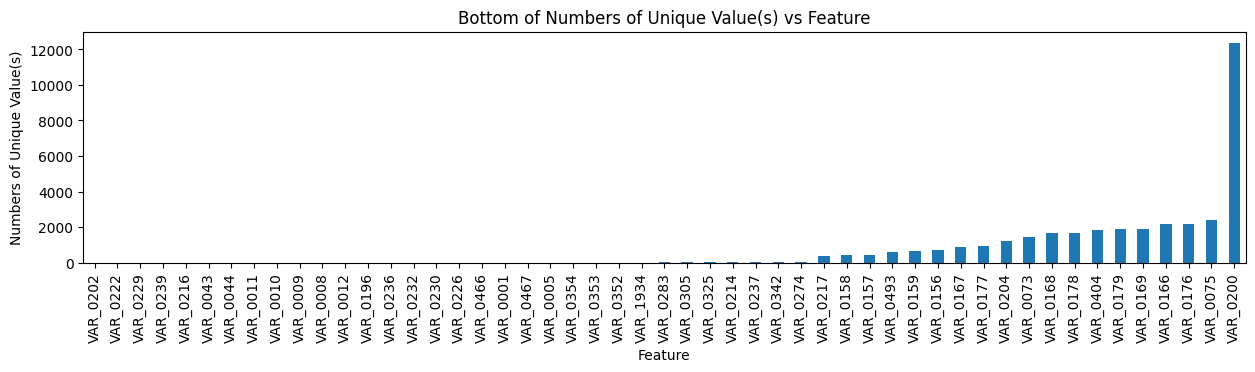

In [14]:
df_cat_cols_low_var = df[df_cat_cols].nunique().sort_values()
df_cat_cols_low_var = df_cat_cols_low_var[df_cat_cols_low_var > 0][:51]
df_cat_cols_low_var.plot(kind='bar',
                       figsize=(15, 3),
                       title=r'Bottom of Numbers of Unique Value(s) vs Feature',
                       xlabel='Feature',
                       ylabel='Numbers of Unique Value(s)')

In [15]:
df_cat_cols_single = df_cat_cols_low_var[df_cat_cols_low_var == 1]
df_cat_cols_single = df_cat_cols_single.index.to_list()

print(f'Numbers of feature(s): {len(df_cat_cols_single)}\nFeatures: {df_cat_cols_single}')

Numbers of feature(s): 13
Features: ['VAR_0202', 'VAR_0222', 'VAR_0229', 'VAR_0239', 'VAR_0216', 'VAR_0043', 'VAR_0044', 'VAR_0011', 'VAR_0010', 'VAR_0009', 'VAR_0008', 'VAR_0012', 'VAR_0196']


##### **D. Missing Value (rows)**

In [16]:
cols = df_cols_null_70p + df_num_cols_single + df_cat_cols_single
threshold_null = 0.2 + len(cols)/len(df)

row_null_count = df.isnull().mean(axis=1)
row_null_count = row_null_count[row_null_count > threshold_null]
df_row_null = row_null_count.index.to_list()

dr_row_null_target_dist = df.iloc[df_row_null]['target'].value_counts()

print(f'Threshold for missing features: {threshold_null}\n')
print(f'Instance(s):\n{row_null_count}\n')
print(f'Instance(s) target distribution: \n{dr_row_null_target_dist}\n')

Threshold for missing features: 0.2005164186709449

Instance(s):
9855      0.271458
11910     0.271458
13018     0.271458
13447     0.271458
16524     0.271458
17461     0.271458
20511     0.271458
25658     0.271458
27429     0.271458
33001     0.271458
36093     0.271458
36534     0.271458
40061     0.271458
40317     0.271458
40848     0.271458
41185     0.271458
43410     0.271458
43629     0.271458
45875     0.271458
55156     0.271458
56206     0.271458
57191     0.271458
58586     0.271458
60229     0.271458
62100     0.271458
62455     0.271458
65682     0.271458
66061     0.271458
70000     0.271458
79003     0.271458
79268     0.271458
84358     0.271458
85066     0.271458
87829     0.271458
88207     0.271458
91939     0.271458
94705     0.271458
94729     0.271458
96148     0.271458
97962     0.271458
105196    0.271458
112029    0.271458
115558    0.271458
117069    0.271458
122319    0.271458
122527    0.271458
124410    0.271458
133942    0.271458
135973    0.271458
1387

# **Approach 1 (Baseline)**

### **Feature engineering**

In [17]:
def convert_str2cat(df_origin: pd.DataFrame) -> pd.DataFrame:
  cat_cols = df_origin.select_dtypes('object').columns
  
  cat_cols = {col: 'category' for col in cat_cols}
  df_origin = df_origin.astype(cat_cols)
  
  return df_origin

df = convert_str2cat(df)

### **Data splitting**

##### **A. Train - test data split**

In [18]:
X, X_test, y, y_test = train_test_split(df.drop(columns=['ID', 'target'], axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['target'])

print(f'Train dataset shape (X): {X.shape}')
print(f'Test dataset shape (X_test): {X_test.shape}')

Train dataset shape (X): (116184, 1932)
Test dataset shape (X_test): (29047, 1932)


##### **B. Data folding**

In [19]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **Model preparation**

In [20]:
classifier = LGBMClassifier(objective='binary', metric='auc', n_jobs=-1)

### **Model training**

In [21]:
X_num_cols = X.select_dtypes(exclude='category').columns
X_cat_cols = X.select_dtypes('category').columns

In [22]:
auc_scores = np.zeros(n_splits)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
  classifier.fit(X_train, y_train, categorical_feature=X_cat_cols.to_list())
  
  y_probs = classifier.predict_proba(X_valid)[:, 1]
  
  auc = roc_auc_score(y_valid, y_probs)
  auc_scores[fold] = auc
  
  print(f'Fold {fold} => AUC score: {auc}')
  
mean_auc = np.mean(auc_scores)
print(f'Mean AUC oof score: {mean_auc:.4f}')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24316, number of negative: 80249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.127568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187174
[LightGBM] [Info] Number of data points in the train set: 104565, number of used features: 1927
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232544 -> initscore=-1.194000
[LightGBM] [Info] Start training from score -1.194000
Fold 0 => AUC score: 0.7355214430440712
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.

<Axes: title={'center': 'Feature Importance LGBM default (AUC = 0.7420)'}, xlabel='Feature', ylabel='Feature Importance'>

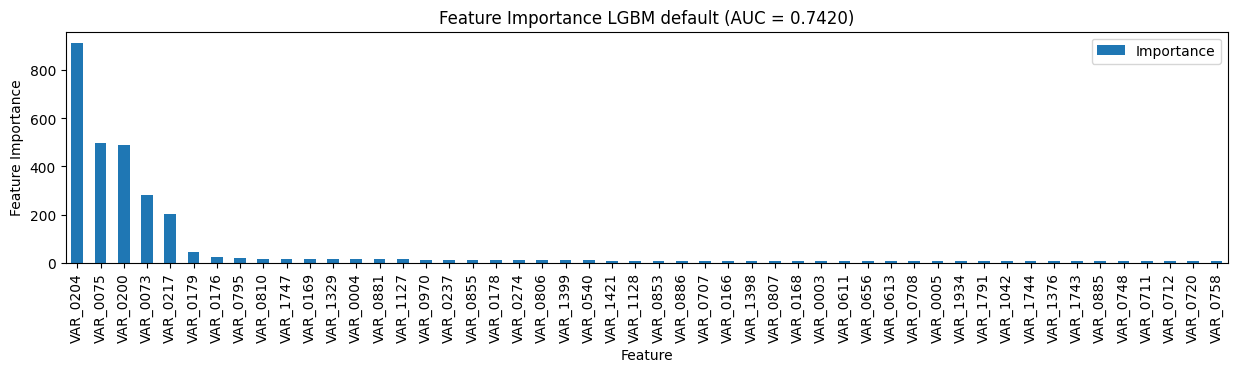

In [23]:
feature_importance_df = pd.DataFrame({'Feature': classifier.feature_name_, 'Importance': classifier.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df[:50].plot(kind='bar',
                                x='Feature',
                                y='Importance',
                                title=f'Feature Importance LGBM default (AUC = {mean_auc:.4f})',
                                xlabel='Feature',
                                ylabel='Feature Importance',
                                figsize=(15, 3))

In [24]:
top_feat_50 = df[feature_importance_df[:50]['Feature']]
top_feat_50.head()

,VAR_0204,VAR_0075,VAR_0200,VAR_0073,VAR_0217,VAR_0179,VAR_0176,VAR_0795,VAR_0810,VAR_1747,VAR_0169,VAR_1329,VAR_0004,VAR_0881,VAR_1127,VAR_0970,VAR_0237,VAR_0855,VAR_0178,VAR_0274,VAR_0806,VAR_1399,VAR_0540,VAR_1421,VAR_1128,VAR_0853,VAR_0886,VAR_0707,VAR_0166,VAR_1398,VAR_0807,VAR_0168,VAR_0003,VAR_0611,VAR_0656,VAR_0613,VAR_0708,VAR_0005,VAR_1934,VAR_1791,VAR_1042,VAR_1744,VAR_1376,VAR_1743,VAR_0885,VAR_0748,VAR_0711,VAR_0712,VAR_0720,VAR_0758
0,29JAN14:21:16:00,08NOV11:00:00:00,FT LAUDERDALE,NaN,08NOV11:02:00:00,NaN,NaN,0,0,999999997,NaN,82,4300,62,100,76857,FL,-99999,NaN,FL,1,999999997,84,999999998,100,-99999,89,107,NaN,999999997,0,NaN,0,39,997,67,1,C,IAPS,0,0,97,1253,97,100,-99999,1,1,1,0
1,01FEB14:00:11:00,10NOV11:00:00:00,SANTEE,04SEP12:00:00:00,02OCT12:02:00:00,NaN,NaN,1,4,999999998,NaN,101,4448,58,100,5296,CA,1,NaN,MI,8,999999998,63,999999998,100,1,95,59,NaN,999999998,2,NaN,53,60,99,100,4,B,IAPS,1,0,98,276,98,92,1,2,9,4,1
2,30JAN14:15:11:00,13DEC11:00:00:00,REEDSVILLE,NaN,13DEC11:02:00:00,NaN,NaN,0,-99999,999999997,NaN,997,3464,-99999,100,999999997,WV,26,NaN,WV,1,7071,48,999999998,100,26,82,69,NaN,2116,-99999,NaN,3,997,995,997,1,C,IAPS,97,0,0,999999997,1,75,0,1,1,1,0
3,01FEB14:00:07:00,23SEP10:00:00:00,LIBERTY,NaN,01NOV12:02:00:00,NaN,NaN,0,0,24915,NaN,95,3200,61,50,6313,TX,3,NaN,TX,5,999999998,65,8601,56,3,72,33,NaN,999999998,0,NaN,300,60,100,60,4,C,RCC,0,3,0,143,0,80,3,1,4,4,7
4,29JAN14:19:31:00,15OCT11:00:00:00,FRANKFORT,NaN,15OCT11:02:00:00,NaN,NaN,0,4,999999998,NaN,99,2000,90,91,13576,IL,6,NaN,IL,4,999999998,84,999999998,92,6,81,134,NaN,999999998,3,NaN,261,101,50,104,2,N,BRANCH,0,0,98,450,98,89,1,1,3,2,1


In [25]:
top_feat_50.nunique()

VAR_0204     1192
VAR_0075     2371
VAR_0200    12385
VAR_0073     1458
VAR_0217      397
VAR_0179     1875
VAR_0176     2163
VAR_0795       27
VAR_0810       23
VAR_1747    18822
VAR_0169     1908
VAR_1329      301
VAR_0004     7935
VAR_0881      253
VAR_1127       99
VAR_0970    25981
VAR_0237       45
VAR_0855       85
VAR_0178     1648
VAR_0274       57
VAR_0806       34
VAR_1399    17471
VAR_0540       86
VAR_1421     8198
VAR_1128      101
VAR_0853      166
VAR_0886      100
VAR_0707      269
VAR_0166     2145
VAR_1398    19744
VAR_0807       18
VAR_0168     1645
VAR_0003      588
VAR_0611      418
VAR_0656      568
VAR_0613      568
VAR_0708       84
VAR_0005        4
VAR_1934        5
VAR_1791       22
VAR_1042       18
VAR_1744       12
VAR_1376     1963
VAR_1743       13
VAR_0885       95
VAR_0748       22
VAR_0711       31
VAR_0712      103
VAR_0720       52
VAR_0758       30
dtype: int64

In [28]:
cat_feat = top_feat_50.select_dtypes('category').columns
num_feat = top_feat_50.select_dtypes(exclude='category').columns

print(f'Numbers of categorical feature(s): {len(cat_feat)}')
print(f'Numbers of numerical feature(s): {len(num_feat)}')

Numbers of categorical feature(s): 15
Numbers of numerical feature(s): 35


In [ ]:
del df, X, X_test, y, y_train, n_splits, skf, classifier, X_num_cols, X_cat_cols, auc_scores, mean_auc, feature_importance_df, top_feat_50, cat_feat, num_feat

# **Approach 2**
Treat missing value as missing and perform imputation to fill the value.

In [33]:
df = pd.read_csv(train_path)
df = save_memory(df)

df.info(memory_usage='deep')

C:\Users\msi.pc\AppData\Local\Temp\ipykernel_10532\1202899172.py:1: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(train_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Columns: 1934 entries, ID to target
dtypes: float32(477), int32(1406), object(51)
memory usage: 1.3 GB


### **Feature Engineering**

##### **A. Drop columns**

In [34]:
columns_to_drop = set(df_cols_null_70p + df_num_cols_single + df_cat_cols_single)
df.drop(columns=columns_to_drop, inplace=True)

print(f'Total dropped columns: {len(columns_to_drop)}')
print(f'Dataset shape: {df.shape}')

Total dropped columns: 75
Dataset shape: (145231, 1859)


##### **B. Drop duplicates**

In [35]:
df_duplicates = df.duplicated()
df.drop_duplicates(inplace=True, keep='first')

print(f'Numbers of duplicated in dataset: {df_duplicates.sum()}')

Numbers of duplicated in dataset: 0


##### **C. Drop rows**

In [36]:
rows_to_drop = df_row_null
df.drop(index=rows_to_drop, axis=0, inplace=True)

print(f'Total dropped rows: {len(rows_to_drop)}')
print(f'Dataset shape: {df.shape}')

Total dropped rows: 53
Dataset shape: (145178, 1859)


##### **D. Categorical data**

In [37]:
df_cat_cols_new = df.select_dtypes('object').columns
df[df_cat_cols_new].head()

,VAR_0001,VAR_0005,VAR_0075,VAR_0200,VAR_0204,VAR_0217,VAR_0226,VAR_0230,VAR_0232,VAR_0236,VAR_0237,VAR_0274,VAR_0283,VAR_0305,VAR_0325,VAR_0342,VAR_0352,VAR_0353,VAR_0354,VAR_0404,VAR_0466,VAR_0467,VAR_0493,VAR_1934
0,H,C,08NOV11:00:00:00,FT LAUDERDALE,29JAN14:21:16:00,08NOV11:02:00:00,False,False,True,True,FL,FL,S,S,-1,CF,O,U,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
1,H,B,10NOV11:00:00:00,SANTEE,01FEB14:00:11:00,02OCT12:02:00:00,False,False,False,True,CA,MI,S,S,H,EC,O,R,R,-1,I,Discharged,-1,IAPS
2,H,C,13DEC11:00:00:00,REEDSVILLE,30JAN14:15:11:00,13DEC11:02:00:00,False,False,True,True,WV,WV,S,P,R,UU,R,R,-1,-1,-1,-1,-1,IAPS
3,H,C,23SEP10:00:00:00,LIBERTY,01FEB14:00:07:00,01NOV12:02:00:00,False,False,False,True,TX,TX,S,P,H,-1,R,R,-1,-1,-1,-1,-1,RCC
4,R,N,15OCT11:00:00:00,FRANKFORT,29JAN14:19:31:00,15OCT11:02:00:00,False,False,True,True,IL,IL,S,P,S,-1,R,U,O,-1,-1,-1,-1,BRANCH


In [38]:
df[df_cat_cols_new].nunique().sort_values(ascending=False)

VAR_0200    12385
VAR_0075     2371
VAR_0404     1823
VAR_0204     1192
VAR_0493      608
VAR_0217      397
VAR_0274       57
VAR_0342       50
VAR_0237       45
VAR_0325        9
VAR_0305        8
VAR_0283        7
VAR_1934        5
VAR_0005        4
VAR_0352        4
VAR_0353        4
VAR_0354        4
VAR_0467        4
VAR_0001        3
VAR_0236        2
VAR_0232        2
VAR_0230        2
VAR_0466        2
VAR_0226        2
dtype: int64

In [39]:
def parse_str2time(df_origin: pd.DataFrame, cols: list, date_format, drop=False):
  for _, col in enumerate(cols):
    parsed_date = pd.to_datetime(df_origin[col], format=date_format)

    df_origin[f'{col}_DAY'] = parsed_date.dt.day
    df_origin[f'{col}_MONTH'] = parsed_date.dt.month
    df_origin[f'{col}_YEAR'] = parsed_date.dt.month
    
    df_origin[f'{col}_HOUR'] = parsed_date.dt.hour
    df_origin[f'{col}_MIN'] = parsed_date.dt.minute
    
    if drop:
      df_origin.drop(columns=[col], inplace=True)
    
  return df_origin

In [40]:
date_format = '%d%b%y:%H:%M:%S'
date_cols = ['VAR_0075', 'VAR_0204', 'VAR_0217']

df = parse_str2time(df_origin=df,
                    cols=date_cols,
                    date_format=date_format,
                    drop=True)
df = save_memory(df)

In [41]:
display(df.filter(like='VAR_0075').head())
display(df.filter(like='VAR_0204').head())
display(df.filter(like='VAR_0217').head())

,VAR_0075_DAY,VAR_0075_MONTH,VAR_0075_YEAR,VAR_0075_HOUR,VAR_0075_MIN
0,8.0,11.0,11.0,0.0,0.0
1,10.0,11.0,11.0,0.0,0.0
2,13.0,12.0,12.0,0.0,0.0
3,23.0,9.0,9.0,0.0,0.0
4,15.0,10.0,10.0,0.0,0.0


,VAR_0204_DAY,VAR_0204_MONTH,VAR_0204_YEAR,VAR_0204_HOUR,VAR_0204_MIN
0,29.0,1.0,1.0,21.0,16.0
1,1.0,2.0,2.0,0.0,11.0
2,30.0,1.0,1.0,15.0,11.0
3,1.0,2.0,2.0,0.0,7.0
4,29.0,1.0,1.0,19.0,31.0


,VAR_0217_DAY,VAR_0217_MONTH,VAR_0217_YEAR,VAR_0217_HOUR,VAR_0217_MIN
0,8.0,11.0,11.0,2.0,0.0
1,2.0,10.0,10.0,2.0,0.0
2,13.0,12.0,12.0,2.0,0.0
3,1.0,11.0,11.0,2.0,0.0
4,15.0,10.0,10.0,2.0,0.0


In [42]:
parsed_date_cols = ['VAR_0075_DAY', 'VAR_0075_MONTH', 'VAR_0075_YEAR', 'VAR_0075_HOUR', 'VAR_0075_MIN',
                    'VAR_0204_DAY', 'VAR_0204_MONTH', 'VAR_0204_YEAR', 'VAR_0204_HOUR', 'VAR_0204_MIN',
                    'VAR_0217_DAY', 'VAR_0217_MONTH', 'VAR_0217_YEAR', 'VAR_0217_HOUR', 'VAR_0217_MIN']

parsed_date_cols_single = df[parsed_date_cols].nunique().sort_values()
parsed_date_cols_single

VAR_0075_HOUR      1
VAR_0075_MIN       1
VAR_0217_HOUR      1
VAR_0217_MIN       1
VAR_0204_MONTH     2
VAR_0204_YEAR      2
VAR_0204_DAY       4
VAR_0075_MONTH    12
VAR_0075_YEAR     12
VAR_0204_HOUR     12
VAR_0217_MONTH    12
VAR_0217_YEAR     12
VAR_0075_DAY      31
VAR_0217_DAY      31
VAR_0204_MIN      60
dtype: int64

In [43]:
parsed_date_cols_single = parsed_date_cols_single[parsed_date_cols_single == 1]
parsed_date_cols_single = parsed_date_cols_single.index.to_list()
parsed_date_cols_single

['VAR_0075_HOUR', 'VAR_0075_MIN', 'VAR_0217_HOUR', 'VAR_0217_MIN']

In [44]:
df.drop(columns=parsed_date_cols_single, axis=1, inplace=True)

In [45]:
df_cat_cols_new = df.select_dtypes('object').columns
df[df_cat_cols_new].head()

,VAR_0001,VAR_0005,VAR_0200,VAR_0226,VAR_0230,VAR_0232,VAR_0236,VAR_0237,VAR_0274,VAR_0283,VAR_0305,VAR_0325,VAR_0342,VAR_0352,VAR_0353,VAR_0354,VAR_0404,VAR_0466,VAR_0467,VAR_0493,VAR_1934
0,H,C,FT LAUDERDALE,False,False,True,True,FL,FL,S,S,-1,CF,O,U,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
1,H,B,SANTEE,False,False,False,True,CA,MI,S,S,H,EC,O,R,R,-1,I,Discharged,-1,IAPS
2,H,C,REEDSVILLE,False,False,True,True,WV,WV,S,P,R,UU,R,R,-1,-1,-1,-1,-1,IAPS
3,H,C,LIBERTY,False,False,False,True,TX,TX,S,P,H,-1,R,R,-1,-1,-1,-1,-1,RCC
4,R,N,FRANKFORT,False,False,True,True,IL,IL,S,P,S,-1,R,U,O,-1,-1,-1,-1,BRANCH


In [46]:
df[df_cat_cols_new].nunique().sort_values(ascending=False)

VAR_0200    12385
VAR_0404     1823
VAR_0493      608
VAR_0274       57
VAR_0342       50
VAR_0237       45
VAR_0325        9
VAR_0305        8
VAR_0283        7
VAR_1934        5
VAR_0005        4
VAR_0352        4
VAR_0353        4
VAR_0354        4
VAR_0467        4
VAR_0001        3
VAR_0236        2
VAR_0232        2
VAR_0230        2
VAR_0466        2
VAR_0226        2
dtype: int64

In [47]:
var200_count = df['VAR_0200'].value_counts()
var200_count[var200_count >= 20]

VAR_0200
CHICAGO         2091
HOUSTON         1306
JACKSONVILLE    1063
SAN ANTONIO     1012
INDIANAPOLIS     866
                ... 
HAINES CITY       20
SAN FERNANDO      20
WILDOMAR          20
RED LION          20
CARMICHAEL        20
Name: count, Length: 1426, dtype: int64

In [48]:
var404_count = df['VAR_0404'].value_counts()
var404_count[var404_count >= 20]

VAR_0404
-1                               130443
CONTACT                            2163
PRESIDENT                          1315
AGENT                              1072
DIRECTOR                            864
OWNER                               770
MEMBER                              566
SECRETARY                           512
INDIVIDUAL - SOLE OWNER             458
MANAGER                             361
INCORPORATOR                        288
VICE PRESIDENT                      267
CONTA                               254
TREASURER                           225
BOARD MEMBER                        167
MEMBER MANAGER                      164
CEO                                 143
OFFICE MANAGER                      106
REGISTRANT                          105
CHIEF EXECUTIVE OFFICER             103
MANAGING MEMBER                     102
TAX RESPONSIBLE PARTY                99
PARTNER                              88
CFO                                  87
ORGANIZER                      

In [49]:
var404_count.filter(like='PRESIDENT')

VAR_0404
PRESIDENT                              1315
VICE PRESIDENT                          267
PRESIDENT, DIRECTOR                      12
VICE-PRESIDENT                           12
DIRECTOR;PRESIDENT                        9
                                       ... 
PRESIDENT,TREASURER                       1
DIRECTOR,VICE PRESIDENT                   1
VICE PRESIDENT, REAL ESTATE               1
DIRECTOR,PRESIDENT,SECRETARY,TREASU       1
EXECUTIVE VICE PRESIDENT, ADVERTISI       1
Name: count, Length: 107, dtype: int64

In [50]:
var493_count = df['VAR_0493'].value_counts()
var493_count[var493_count >= 20]

VAR_0493
-1                                      135182
REGISTERED NURSE                          1099
LICENSED PRACTICAL NURSE                   767
PHARMACY TECHNICIAN                        536
COSMETOLOGIST                              452
GUARD                                      399
PERMANENT EMPLOYEE REGISTRATION CARD       325
PROFESSIONAL NURSE                         246
LICENSED VOCATIONAL NURSE                  243
NURSE AIDE                                 238
CERTIFIED NURSING ASSISTANT                238
REAL ESTATE                                226
PRACTICAL NURSE                            141
CERTIFIED NURSE AIDE                       111
INSURANCE AGENTS                            98
LICENSED REAL ESTATE SALESPERSON            89
REGISTERED PROFESSIONAL NURSE               86
FIREARM PERMIT                              85
MASTER COSMETOLOGIST                        79
REAL ESTATE SALESPERSON                     75
RN                                          70
VOCA

### **Data splitting**

##### **A. Train - test data split**

In [51]:
X, X_test, y, y_test = train_test_split(df.drop(columns=['ID', 'target'], axis=1),
                                                    df['target'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['target'])

print(f'Train dataset shape (X): {X.shape}')
print(f'Test dataset shape (X_test): {X_test.shape}')

Train dataset shape (X): (116142, 1865)
Test dataset shape (X_test): (29036, 1865)


##### **B. Data folding**

In [52]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **Data preprocessing**

In [53]:
X_num_cols = X.select_dtypes(exclude='object').columns
X_cat_cols = X.select_dtypes('object').columns

##### **A. Numerical data**

In [54]:
def num_col_preprocessor(X_train_origin: pd.DataFrame, X_test_origin: pd.DataFrame, imputer=None, scaler=None, num_cols=None):
  if not num_cols: num_cols = []
  
  train = X_train_origin.copy()
  test = X_test_origin.copy()
  
  if imputer:
    train[num_cols] = imputer.fit_transform(train[num_cols])
    test[num_cols] = imputer.transform(test[num_cols])
    
  if scaler:
    train[num_cols] = scaler.fit_transform(train[num_cols])
    test[num_cols] = scaler.transform(test[num_cols])

  return (train, test)

##### **B. Categorical data**

In [55]:
def convert_str2cat(df_origin: pd.DataFrame) -> pd.DataFrame:
  cat_cols = df_origin.select_dtypes('object').columns
  
  cat_cols = {col: 'category' for col in cat_cols}
  df_origin = df_origin.astype(cat_cols)
  
  return df_origin

def cat_col_preprocessor(X_train_origin: pd.DataFrame, X_test_origin: pd.DataFrame, imputer=None, encoder=None, cat_cols=None):
  if not cat_cols: cat_cols = []
  
  train = X_train_origin.copy()
  test = X_test_origin.copy()
  
  if imputer:
    train[cat_cols] = imputer.fit_transform(train[cat_cols])
    test[cat_cols] = imputer.transform(test[cat_cols])
    
  if encoder:
    train[cat_cols] = encoder.fit_transform(train[cat_cols])
    test[cat_cols] = encoder.transform(test[cat_cols])
    
  train[cat_cols] = convert_str2cat(train[cat_cols])
  test[cat_cols] = convert_str2cat(test[cat_cols])

  return (train, test)

##### **C. Taget encoding**

In [56]:
def target_encoding(train_target: pd.Series, test_target: pd.Series, encoder):
  train_target_enc = encoder.fit_transform(train_target)
  test_target_enc = encoder.transform(test_target)
  
  return (train_target_enc, test_target_enc)

##### **D. Imbalanced data**

In [57]:
def resampling(X_train_origin: pd.DataFrame, y_train_origin: pd.Series, sampler):
  X_res, y_res = sampler.fit_resample(X_train_origin, y_train_origin)
  
  return (X_res, y_res)

### **Model preparation**

##### **A. Build pipeline**

In [58]:
classifier = LGBMClassifier(objective='binary', metric='auc', n_jobs=-1)

num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
num_scaler = RobustScaler()
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
label_encoder = LabelEncoder()
sampler = RandomUnderSampler(random_state=42)

def preprocessor(X_tr, X_ts, y_tr, y_ts):
  X_tr_pre, X_ts_pre = num_col_preprocessor(X_tr, X_ts, imputer=num_imputer, scaler=num_scaler, num_cols=X_num_cols.to_list())
  X_tr_pre, X_ts_pre = cat_col_preprocessor(X_tr_pre, X_ts_pre, imputer=cat_imputer, cat_cols=X_cat_cols.to_list())
  y_tr_pre, y_ts_pre = target_encoding(y_tr, y_ts, label_encoder)
  X_tr_pre, y_tr_pre = resampling(X_tr_pre, y_tr_pre, sampler)
  
  return [X_tr_pre, X_ts_pre, y_tr_pre, y_ts_pre]
  

### **Model training**

In [59]:
auc_scores = np.zeros(n_splits)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
  
  X_train, X_valid, y_train, y_valid = preprocessor(X_train, X_valid, y_train, y_valid)
  
  classifier.fit(X_train, y_train, categorical_feature=X_cat_cols.to_list())
  
  y_probs = classifier.predict_proba(X_valid)[:, 1]
  
  auc = roc_auc_score(y_valid, y_probs)
  auc_scores[fold] = auc
  
  print(f'Fold {fold} => AUC score: {auc}')
  
mean_auc = np.mean(auc_scores)
print(f'Mean AUC oof score: {mean_auc:.4f}')

[LightGBM] [Info] Number of positive: 24307, number of negative: 24307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.548506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162287
[LightGBM] [Info] Number of data points in the train set: 48614, number of used features: 1862
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fold 0 => AUC score: 0.7765738713347677
[LightGBM] [Info] Number of positive: 24307, number of negative: 24307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.611146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 162253
[LightGBM] [Info] Number of data points in the train set: 48614, number of used features: 1863
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fold 1 => AUC score: 0.7667681312325262
[LightGBM] [Warning] Categorical f

<Axes: title={'center': 'Feature Importance LGBM default (AUC = 0.7670)'}, xlabel='Feature', ylabel='Feature Importance'>

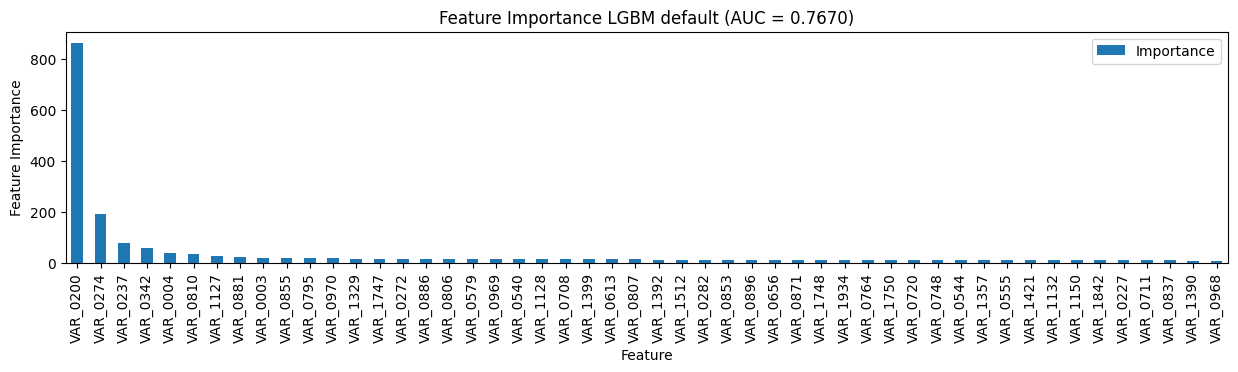

In [60]:
feature_importance_df = pd.DataFrame({'Feature': classifier.feature_name_, 'Importance': classifier.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df[:50].plot(kind='bar',
                                x='Feature',
                                y='Importance',
                                title=f'Feature Importance LGBM default (AUC = {mean_auc:.4f})',
                                xlabel='Feature',
                                ylabel='Feature Importance',
                                figsize=(15, 3))

In [61]:
top_feat_50 = df[feature_importance_df[:50]['Feature']]
top_feat_50.head()

,VAR_0200,VAR_0274,VAR_0237,VAR_0342,VAR_0004,VAR_0810,VAR_1127,VAR_0881,VAR_0003,VAR_0855,VAR_0795,VAR_0970,VAR_1329,VAR_1747,VAR_0272,VAR_0886,VAR_0806,VAR_0579,VAR_0969,VAR_0540,VAR_1128,VAR_0708,VAR_1399,VAR_0613,VAR_0807,VAR_1392,VAR_1512,VAR_0282,VAR_0853,VAR_0896,VAR_0656,VAR_0871,VAR_1748,VAR_1934,VAR_0764,VAR_1750,VAR_0720,VAR_0748,VAR_0544,VAR_1357,VAR_0555,VAR_1421,VAR_1132,VAR_1150,VAR_1842,VAR_0227,VAR_0711,VAR_0837,VAR_1390,VAR_0968
0,FT LAUDERDALE,FL,FL,CF,4300,0,100,62,0,-99999,0,76857,82,999999997,595.0,89,1,65,4,84,100,1,999999997,67,0,2,997,347.0,-99999,49463,997,41,999999997,IAPS,-99999,65,1,-99999,3230,668,9996,999999998,24,9994,134,311951.0,1,-99999,0,116783
1,SANTEE,MI,CA,EC,4448,4,100,58,53,1,1,5296,101,999999998,326.0,95,8,37,8,63,100,4,999999998,100,2,0,97,6.0,1,3193,99,10,999999998,IAPS,-99999,9998,4,1,899,103,9996,999999998,8,9994,54,2769488.0,2,1,0,8122
2,REEDSVILLE,WV,WV,UU,3464,-99999,100,-99999,3,26,0,999999997,997,999999997,303.0,82,1,57,1,48,100,1,7071,997,-99999,1,55,-1.0,26,-99999,995,73,999999997,IAPS,-99999,61,1,0,0,999999997,64,999999998,7,9994,65,654127.0,1,0,0,1100
3,LIBERTY,TX,TX,-1,3200,0,50,61,300,3,0,6313,95,24915,484.0,72,5,21,4,65,56,4,999999998,60,0,0,77,131.0,3,183,100,21,37083,RCC,7,1,4,3,286,30,78,8601,1,74,94,3015088.0,1,3,3426,6341
4,FRANKFORT,IL,IL,-1,2000,4,91,90,261,6,0,13576,99,999999998,520.0,81,4,96,9,84,92,2,999999998,104,3,0,48,137.0,6,9588,50,4,999999998,BRANCH,-99999,9998,2,1,947,353,35,999999998,18,37,149,118678.0,1,1,0,14761


In [62]:
top_feat_50.nunique()

VAR_0200     12385
VAR_0274        57
VAR_0237        45
VAR_0342        50
VAR_0004      7935
VAR_0810        23
VAR_1127        99
VAR_0881       253
VAR_0003       588
VAR_0855        85
VAR_0795        27
VAR_0970     25975
VAR_1329       301
VAR_1747     18820
VAR_0272       757
VAR_0886       100
VAR_0806        34
VAR_0579       364
VAR_0969        49
VAR_0540        86
VAR_1128       101
VAR_0708        84
VAR_1399     17468
VAR_0613       568
VAR_0807        18
VAR_1392        60
VAR_1512       231
VAR_0282       636
VAR_0853       166
VAR_0896     17620
VAR_0656       568
VAR_0871       324
VAR_1748     20609
VAR_1934         5
VAR_0764        29
VAR_1750       300
VAR_0720        52
VAR_0748        22
VAR_0544      6162
VAR_1357      1688
VAR_0555        87
VAR_1421      8197
VAR_1132       129
VAR_1150       375
VAR_1842       369
VAR_0227    145171
VAR_0711        31
VAR_0837        14
VAR_1390     12623
VAR_0968     27745
dtype: int64

In [64]:
cat_feat = top_feat_50.select_dtypes('object').columns
num_feat = top_feat_50.select_dtypes(exclude='object').columns

print(f'Numbers of categorical feature(s): {len(cat_feat)}')
print(f'Numbers of numerical feature(s): {len(num_feat)}')

Numbers of categorical feature(s): 5
Numbers of numerical feature(s): 45
